In [33]:
import sys
sys.path.append('../')

In [34]:
from utils import * 

In [64]:
import pandas as pd
import numpy as np
%load_ext autoreload
%autoreload 2

%matplotlib inline

In [57]:
import os
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display

from sklearn import metrics
from sklearn_pandas import DataFrameMapper
from sklearn.preprocessing import LabelEncoder, Imputer, StandardScaler
from pandas.api.types import is_string_dtype, is_numeric_dtype
from sklearn.ensemble import forest
from sklearn.tree import export_graphviz
import IPython, graphviz, re
import math

In [88]:
PATH = "data/bluebook-for-bulldozers/"

In [37]:
!ls {PATH}

Data Dictionary.xlsx
Machine_Appendix.csv
Test.csv
Train
Train.7z
Train.csv
TrainAndValid.7z
TrainAndValid.csv
TrainAndValid.zip
Valid.7z
Valid.csv
Valid.zip
ValidSolution.csv
median_benchmark.csv
random_forest_benchmark_test.csv


In [89]:
df_raw = pd.read_csv(f'{PATH}Train.csv', low_memory=False, 
                     parse_dates=["saledate"])

In [90]:
def display_all(df):
    with pd.option_context("display.max_rows", 1000, "display.max_columns", 1000): 
        display(df)

In [40]:
display_all(df_raw.head().T)

,0,1,2,3,4
SalesID,1139246,1139248,1139249,1139251,1139253
SalePrice,66000,57000,10000,38500,11000
MachineID,999089,117657,434808,1026470,1057373
ModelID,3157,77,7009,332,17311
datasource,121,121,121,121,121
auctioneerID,3,3,3,3,3
YearMade,2004,1996,2001,2001,2007
MachineHoursCurrentMeter,68,4640,2838,3486,722
UsageBand,Low,Low,High,High,Medium
saledate,2006-11-16 00:00:00,2004-03-26 00:00:00,2004-02-26 00:00:00,2011-05-19 00:00:00,2009-07-23 00:00:00


In [41]:
df_raw.SalePrice = np.log(df_raw.SalePrice)

In [91]:
def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

In [92]:
add_datepart(df_raw, 'saledate')
df_raw.saleYear.head()

0    2006
1    2004
2    2004
3    2011
4    2009
Name: saleYear, dtype: int64

In [93]:
train_cats(df_raw)

In [94]:
def draw_tree(t, df, size=10, ratio=0.6, precision=0):
    """ Draws a representation of a random forest in IPython.

    Parameters:
    -----------
    t: The tree you wish to draw
    df: The data used to train the tree. This is used to get the names of the features.
    """
    s=export_graphviz(t, out_file=None, feature_names=df.columns, filled=True,
                      special_characters=True, rotate=True, precision=precision)
    IPython.display.display(graphviz.Source(re.sub('Tree {',
       f'Tree {{ size={size}; ratio={ratio}', s)))


def get_sample(df,n):
    """ Gets a random sample of n rows from df, without replacement.

    Parameters:
    -----------
    df: A pandas data frame, that you wish to sample from.
    n: The number of rows you wish to sample.

    Returns:
    --------
    return value: A random sample of n rows of df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    >>> get_sample(df, 2)
       col1 col2
    1     2    b
    2     3    a
    """
    idxs = sorted(np.random.permutation(len(df))[:n])
    return df.iloc[idxs].copy()

def add_datepart(df, fldname, drop=True, time=False, errors="raise"):
    """add_datepart converts a column of df from a datetime64 to many columns containing
    the information from the date. This applies changes inplace.

    Parameters:
    -----------
    df: A pandas data frame. df gain several new columns.
    fldname: A string that is the name of the date column you wish to expand.
        If it is not a datetime64 series, it will be converted to one with pd.to_datetime.
    drop: If true then the original date column will be removed.
    time: If true time features: Hour, Minute, Second will be added.

    Examples:
    ---------

    >>> df = pd.DataFrame({ 'A' : pd.to_datetime(['3/11/2000', '3/12/2000', '3/13/2000'], infer_datetime_format=False) })
    >>> df

        A
    0   2000-03-11
    1   2000-03-12
    2   2000-03-13

    >>> add_datepart(df, 'A')
    >>> df

        AYear AMonth AWeek ADay ADayofweek ADayofyear AIs_month_end AIs_month_start AIs_quarter_end AIs_quarter_start AIs_year_end AIs_year_start AElapsed
    0   2000  3      10    11   5          71         False         False           False           False             False        False          952732800
    1   2000  3      10    12   6          72         False         False           False           False             False        False          952819200
    2   2000  3      11    13   0          73         False         False           False           False             False        False          952905600
    """
    fld = df[fldname]
    fld_dtype = fld.dtype
    if isinstance(fld_dtype, pd.core.dtypes.dtypes.DatetimeTZDtype):
        fld_dtype = np.datetime64

    if not np.issubdtype(fld_dtype, np.datetime64):
        df[fldname] = fld = pd.to_datetime(fld, infer_datetime_format=True, errors=errors)
    targ_pre = re.sub('[Dd]ate$', '', fldname)
    attr = ['Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'Is_month_end', 'Is_month_start', 'Is_quarter_end', 'Is_quarter_start', 'Is_year_end', 'Is_year_start']
    if time: attr = attr + ['Hour', 'Minute', 'Second']
    for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())
    df[targ_pre + 'Elapsed'] = fld.astype(np.int64) // 10 ** 9
    if drop: df.drop(fldname, axis=1, inplace=True)

def train_cats(df):
    """Change any columns of strings in a panda's dataframe to a column of
    categorical values. This applies the changes inplace.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values.

    Examples:
    ---------

    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category
    """
    for n,c in df.items():
        if is_string_dtype(c): df[n] = c.astype('category').cat.as_ordered()

def apply_cats(df, trn):
    """Changes any columns of strings in df into categorical variables using trn as
    a template for the category codes.

    Parameters:
    -----------
    df: A pandas dataframe. Any columns of strings will be changed to
        categorical values. The category codes are determined by trn.

    trn: A pandas dataframe. When creating a category for df, it looks up the
        what the category's code were in trn and makes those the category codes
        for df.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category {a : 1, b : 2}

    >>> df2 = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['b', 'a', 'a']})
    >>> apply_cats(df2, df)

           col1 col2
        0     1    b
        1     2    a
        2     3    a

    now the type of col is category {a : 1, b : 2}
    """
    for n,c in df.items():
        if (n in trn.columns) and (trn[n].dtype.name=='category'):
            df[n] = c.astype('category').cat.as_ordered()
            df[n].cat.set_categories(trn[n].cat.categories, ordered=True, inplace=True)

def fix_missing(df, col, name, na_dict):
    """ Fill missing data in a column of df with the median, and add a {name}_na column
    which specifies if the data was missing.

    Parameters:
    -----------
    df: The data frame that will be changed.

    col: The column of data to fix by filling in missing data.

    name: The name of the new filled column in df.

    na_dict: A dictionary of values to create na's of and the value to insert. If
        name is not a key of na_dict the median will fill any missing data. Also
        if name is not a key of na_dict and there is no missing data in col, then
        no {name}_na column is not created.


    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1     2    2    True
    2     3    2   False


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col2'], 'col2', {})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2


    >>> df = pd.DataFrame({'col1' : [1, np.NaN, 3], 'col2' : [5, 2, 2]})
    >>> df
       col1 col2
    0     1    5
    1   nan    2
    2     3    2

    >>> fix_missing(df, df['col1'], 'col1', {'col1' : 500})
    >>> df
       col1 col2 col1_na
    0     1    5   False
    1   500    2    True
    2     3    2   False
    """
    if is_numeric_dtype(col):
        if pd.isnull(col).sum() or (name in na_dict):
            df[name+'_na'] = pd.isnull(col)
            filler = na_dict[name] if name in na_dict else col.median()
            df[name] = col.fillna(filler)
            na_dict[name] = filler
    return na_dict

def numericalize(df, col, name, max_n_cat):
    """ Changes the column col from a categorical type to it's integer codes.

    Parameters:
    -----------
    df: A pandas dataframe. df[name] will be filled with the integer codes from
        col.

    col: The column you wish to change into the categories.
    name: The column name you wish to insert into df. This column will hold the
        integer codes.

    max_n_cat: If col has more categories than max_n_cat it will not change the
        it to its integer codes. If max_n_cat is None, then col will always be
        converted.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> numericalize(df, df['col2'], 'col3', None)

       col1 col2 col3
    0     1    a    1
    1     2    b    2
    2     3    a    1
    """
    if not is_numeric_dtype(col) and ( max_n_cat is None or len(col.cat.categories)>max_n_cat):
        df[name] = col.cat.codes+1

def scale_vars(df, mapper):
    warnings.filterwarnings('ignore', category=sklearn.exceptions.DataConversionWarning)
    if mapper is None:
        map_f = [([n],StandardScaler()) for n in df.columns if is_numeric_dtype(df[n])]
        mapper = DataFrameMapper(map_f).fit(df)
    df[mapper.transformed_names_] = mapper.transform(df)
    return mapper

def proc_df(df, y_fld=None, skip_flds=None, ignore_flds=None, do_scale=False, na_dict=None,
            preproc_fn=None, max_n_cat=None, subset=None, mapper=None):
    """ proc_df takes a data frame df and splits off the response variable, and
    changes the df into an entirely numeric dataframe. For each column of df 
    which is not in skip_flds nor in ignore_flds, na values are replaced by the
    median value of the column.

    Parameters:
    -----------
    df: The data frame you wish to process.

    y_fld: The name of the response variable

    skip_flds: A list of fields that dropped from df.

    ignore_flds: A list of fields that are ignored during processing.

    do_scale: Standardizes each column in df. Takes Boolean Values(True,False)

    na_dict: a dictionary of na columns to add. Na columns are also added if there
        are any missing values.

    preproc_fn: A function that gets applied to df.

    max_n_cat: The maximum number of categories to break into dummy values, instead
        of integer codes.

    subset: Takes a random subset of size subset from df.

    mapper: If do_scale is set as True, the mapper variable
        calculates the values used for scaling of variables during training time (mean and standard deviation).

    Returns:
    --------
    [x, y, nas, mapper(optional)]:

        x: x is the transformed version of df. x will not have the response variable
            and is entirely numeric.

        y: y is the response variable

        nas: returns a dictionary of which nas it created, and the associated median.

        mapper: A DataFrameMapper which stores the mean and standard deviation of the corresponding continuous
        variables which is then used for scaling of during test-time.

    Examples:
    ---------
    >>> df = pd.DataFrame({'col1' : [1, 2, 3], 'col2' : ['a', 'b', 'a']})
    >>> df
       col1 col2
    0     1    a
    1     2    b
    2     3    a

    note the type of col2 is string

    >>> train_cats(df)
    >>> df

       col1 col2
    0     1    a
    1     2    b
    2     3    a

    now the type of col2 is category { a : 1, b : 2}

    >>> x, y, nas = proc_df(df, 'col1')
    >>> x

       col2
    0     1
    1     2
    2     1

    >>> data = DataFrame(pet=["cat", "dog", "dog", "fish", "cat", "dog", "cat", "fish"],
                 children=[4., 6, 3, 3, 2, 3, 5, 4],
                 salary=[90, 24, 44, 27, 32, 59, 36, 27])

    >>> mapper = DataFrameMapper([(:pet, LabelBinarizer()),
                          ([:children], StandardScaler())])

    >>>round(fit_transform!(mapper, copy(data)), 2)

    8x4 Array{Float64,2}:
    1.0  0.0  0.0   0.21
    0.0  1.0  0.0   1.88
    0.0  1.0  0.0  -0.63
    0.0  0.0  1.0  -0.63
    1.0  0.0  0.0  -1.46
    0.0  1.0  0.0  -0.63
    1.0  0.0  0.0   1.04
    0.0  0.0  1.0   0.21
    """
    if not ignore_flds: ignore_flds=[]
    if not skip_flds: skip_flds=[]
    if subset: df = get_sample(df,subset)
    else: df = df.copy()
    ignored_flds = df.loc[:, ignore_flds]
    df.drop(ignore_flds, axis=1, inplace=True)
    if preproc_fn: preproc_fn(df)
    if y_fld is None: y = None
    else:
        if not is_numeric_dtype(df[y_fld]): df[y_fld] = df[y_fld].cat.codes
        y = df[y_fld].values
        skip_flds += [y_fld]
    df.drop(skip_flds, axis=1, inplace=True)

    if na_dict is None: na_dict = {}
    else: na_dict = na_dict.copy()
    na_dict_initial = na_dict.copy()
    for n,c in df.items(): na_dict = fix_missing(df, c, n, na_dict)
    if len(na_dict_initial.keys()) > 0:
        df.drop([a + '_na' for a in list(set(na_dict.keys()) - set(na_dict_initial.keys()))], axis=1, inplace=True)
    if do_scale: mapper = scale_vars(df, mapper)
    for n,c in df.items(): numericalize(df, c, n, max_n_cat)
    df = pd.get_dummies(df, dummy_na=True)
    df = pd.concat([ignored_flds, df], axis=1)
    res = [df, y, na_dict]
    if do_scale: res = res + [mapper]
    return res

In [95]:
df, y, nas = proc_df(df_raw, 'SalePrice')

In [96]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()

n_valid = 12000  # same as Kaggle's test set size
n_trn = len(df)-n_valid
raw_train, raw_valid = split_vals(df_raw, n_trn)
X_train, X_valid = split_vals(df, n_trn)
y_train, y_valid = split_vals(y, n_trn)

X_train.shape, y_train.shape, X_valid.shape

((389125, 66), (389125,), (12000, 66))

In [97]:
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

def print_score(m):
    res = [rmse(m.predict(X_train), y_train), rmse(m.predict(X_valid), y_valid),
                m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [98]:
set_rf_samples(20000)

In [99]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[8064.724240691786, 9058.651352030987, 0.8770268064039359, 0.8604454427041635, 0.8680120816820948]


In [100]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [101]:
fi = rf_feat_importance(m, X_train); fi[:10]

,cols,imp
5,YearMade,0.194052
13,ProductSize,0.151860
10,fiSecondaryDesc,0.074146
19,Enclosure,0.059456
63,saleElapsed,0.056932
14,fiProductClassDesc,0.053832
2,ModelID,0.048482
9,fiBaseModel,0.043120
12,fiModelDescriptor,0.034335
8,fiModelDesc,0.032476


In [102]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

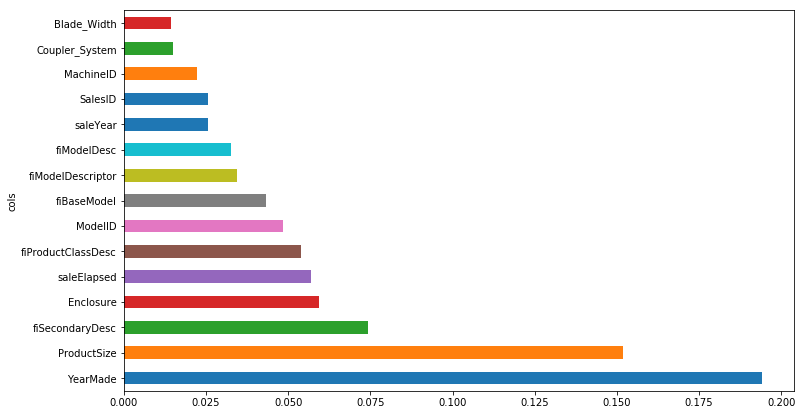

In [103]:
plot_fi(fi[:15])

In [104]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

27

In [105]:
X_train = X_train[to_keep]
X_valid = X_valid[to_keep]

In [106]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[8117.395379352, 9016.621584945267, 0.8754152722206113, 0.8617374315989331, 0.8665438229200144]


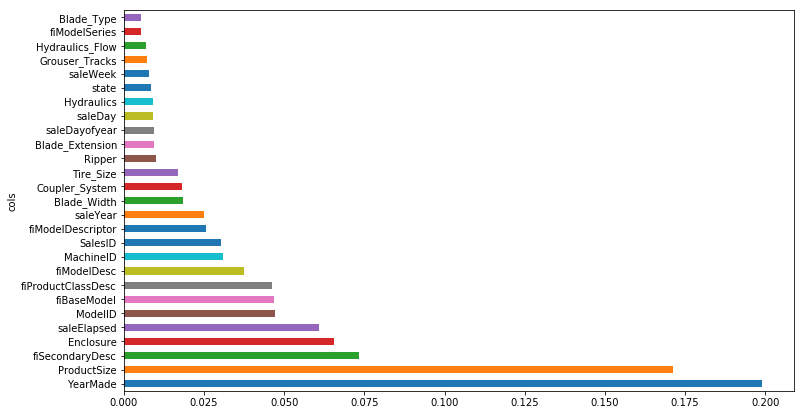

In [107]:
fi = rf_feat_importance(m, X_train)
plot_fi(fi);

In [108]:
from scipy.cluster import hierarchy as hc
import scipy
from matplotlib import pyplot as plt

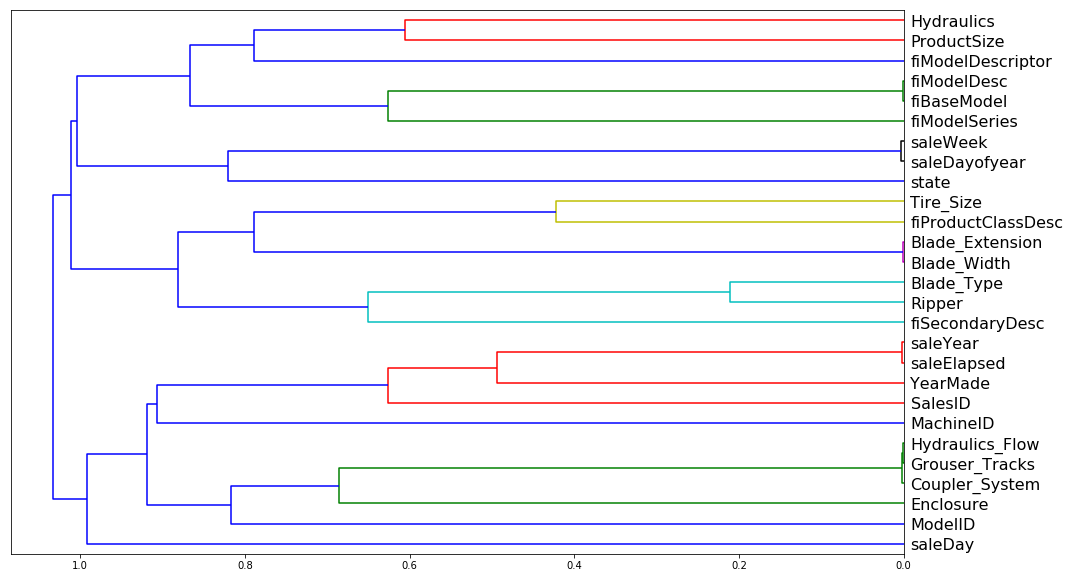

In [109]:
corr = np.round(scipy.stats.spearmanr(X_train).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train.columns, orientation='left', leaf_font_size=16)
plt.show()

In [80]:
from treeinterpreter import treeinterpreter as ti

In [110]:
df_train, df_valid = split_vals(df_raw[X_train.columns], n_trn)

In [112]:
row = X_valid.values[None,0]; row

array([[      1999,          5,          0,          1, 1284595200,
                17,        665,       1111,          0,       3232,
              2010,    4364751,    2300944,          0,          0,
                 0,          0,         12,          0,         16,
                35,        259,          0,         37,          0,
                 0,         63]], dtype=int64)

In [113]:
prediction, bias, contributions = ti.predict(m, row)

In [114]:
prediction[0], bias[0]

(array([13457.66666667]), 31100.4001525)

In [115]:
idxs = np.argsort(contributions[0])

In [117]:
[o for o in zip(X_train.columns[idxs], df_valid.iloc[0][idxs], contributions[0][idxs])]

[('ProductSize', 'Mini', -10711.476138131464),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -2649.14348062972),
 ('saleElapsed', 1284595200, -1683.9341310699049),
 ('Enclosure', 'EROPS', -1377.9297130991024),
 ('saleYear', 2010, -1023.9973954073218),
 ('fiModelDescriptor', nan, -893.4251635183798),
 ('SalesID', 4364751, -841.8769367770632),
 ('fiBaseModel', 'KX121', -824.3615641477994),
 ('fiModelDesc', 'KX1212', -451.67046975023675),
 ('saleDayofyear', 259, -396.7574060509695),
 ('fiSecondaryDesc', nan, -382.5772399901316),
 ('Tire_Size', nan, -347.40121901413283),
 ('MachineID', 2300944, -344.1756379740019),
 ('Blade_Type', nan, -211.418896998982),
 ('saleWeek', 37, -37.30072767993065),
 ('saleDay', 16, -34.155274963846026),
 ('Ripper', nan, -25.3176179137301),
 ('Blade_Extension', nan, 0.0),
 ('Hydraulics_Flow', nan, 0.0),
 ('Blade_Width', nan, 0.0),
 ('Hydraulics', 'Standard', 51.52887544603082),
 ('state', 'Ohio', 94.42013245805178),
 ('Grouse

In [121]:
m = RandomForestRegressor(n_estimators=1, max_depth=2, bootstrap=False, n_jobs=-1)
m.fit(X_train, y_train)

RandomForestRegressor(bootstrap=False, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

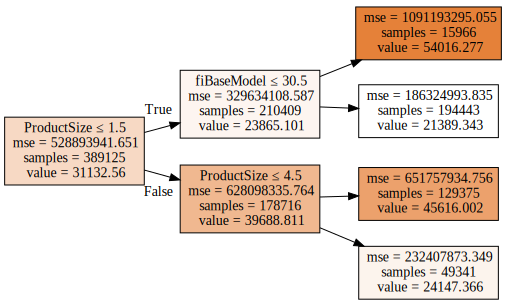

In [122]:
draw_tree(m.estimators_[0], X_train, precision=3)